<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score, make_scorer

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')
print(data.head())

   ClientPeriod  MonthlySpending TotalSpent     Sex  IsSeniorCitizen  \
0            55            19.50    1026.35    Male                0   
1            72            25.85     1872.2    Male                0   
2             1            75.90       75.9    Male                0   
3            32            79.30       2570  Female                1   
4            60           115.25    6758.45  Female                0   

  HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
0        Yes      Yes             Yes                      No   
1        Yes       No             Yes                     Yes   
2         No       No             Yes                      No   
3        Yes       No             Yes                     Yes   
4        Yes      Yes             Yes                     Yes   

  HasInternetService HasOnlineSecurityService      HasOnlineBackup  \
0                 No      No internet service  No internet service   
1                 No      No interne

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'
cols = feature_cols + [target_col]
data = data[cols]

In [5]:
print(data.info())
print(np.sum(data.isna()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

TotalSpent приведем к типу float и избавимся от пустых записей

In [6]:
space_inds = []
for i in range(len(data['TotalSpent'])):
    try:
        data['TotalSpent'][i] = float(data['TotalSpent'][i])
    except Exception:
        space_inds.append(i)
data = data.drop(space_inds)        
data['TotalSpent'] = data['TotalSpent'].astype(float)
print(data.info())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5273 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5273 non-null   int64  
 1   MonthlySpending           5273 non-null   float64
 2   TotalSpent                5273 non-null   float64
 3   Sex                       5273 non-null   object 
 4   IsSeniorCitizen           5273 non-null   int64  
 5   HasPartner                5273 non-null   object 
 6   HasChild                  5273 non-null   object 
 7   HasPhoneService           5273 non-null   object 
 8   HasMultiplePhoneNumbers   5273 non-null   object 
 9   HasInternetService        5273 non-null   object 
 10  HasOnlineSecurityService  5273 non-null   object 
 11  HasOnlineBackup           5273 non-null   object 
 12  HasDeviceProtection       5273 non-null   object 
 13  HasTechSupportAccess      5273 non-null   object 
 14  HasOnlin

В датасете отсутствуют незаполненые значения.

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

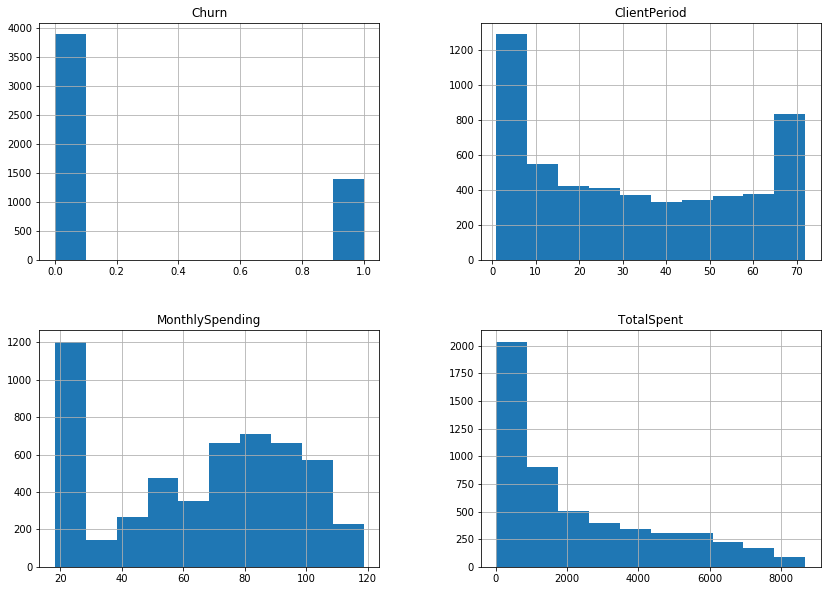

In [7]:
data.hist(column=num_cols+[target_col], figsize=(14, 10))
None

In [8]:
for col in cat_cols:
  print(data[col].value_counts())

Male      2651
Female    2622
Name: Sex, dtype: int64
0    4431
1     842
Name: IsSeniorCitizen, dtype: int64
No     2704
Yes    2569
Name: HasPartner, dtype: int64
No     3676
Yes    1597
Name: HasChild, dtype: int64
Yes    4754
No      519
Name: HasPhoneService, dtype: int64
No                  2508
Yes                 2246
No phone service     519
Name: HasMultiplePhoneNumbers, dtype: int64
Fiber optic    2341
DSL            1795
No             1137
Name: HasInternetService, dtype: int64
No                     2611
Yes                    1525
No internet service    1137
Name: HasOnlineSecurityService, dtype: int64
No                     2331
Yes                    1805
No internet service    1137
Name: HasOnlineBackup, dtype: int64
No                     2316
Yes                    1820
No internet service    1137
Name: HasDeviceProtection, dtype: int64
No                     2603
Yes                    1533
No internet service    1137
Name: HasTechSupportAccess, dtype: int64
No    

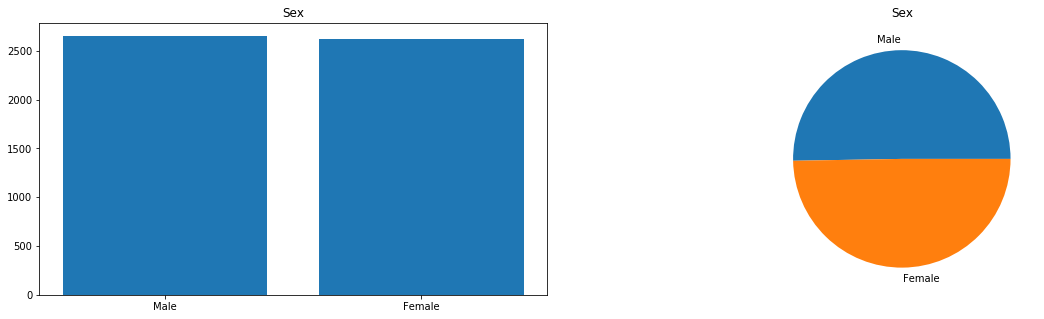

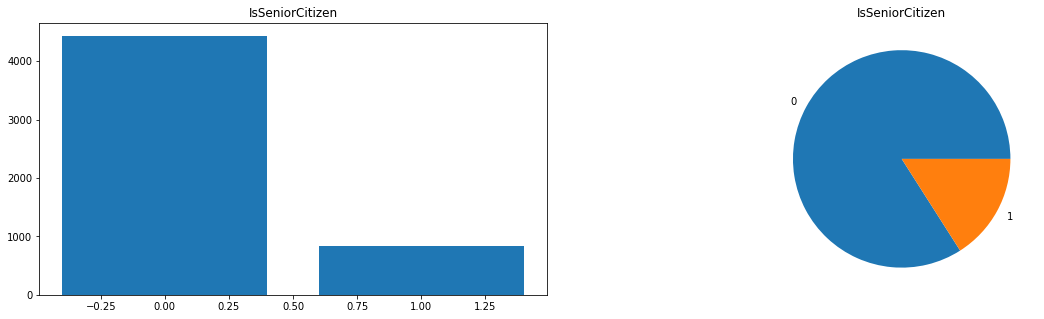

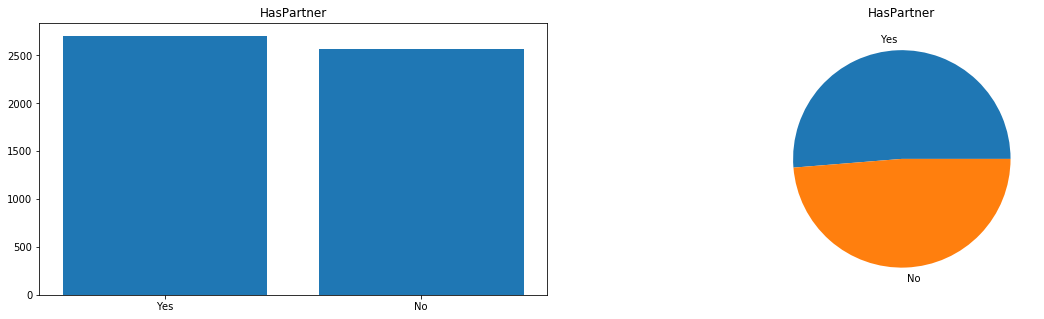

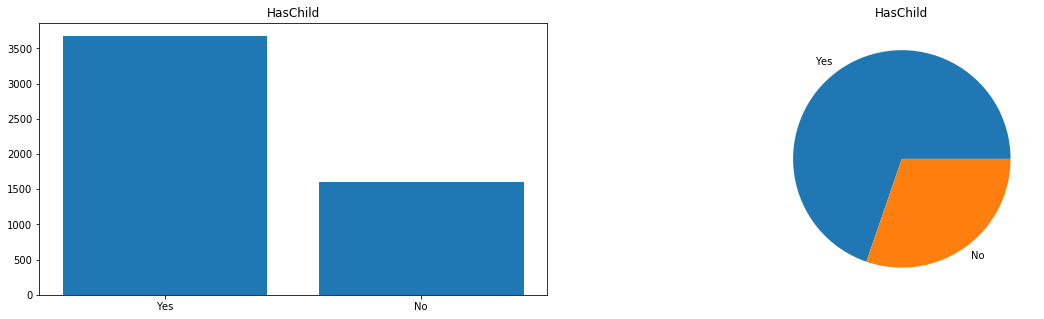

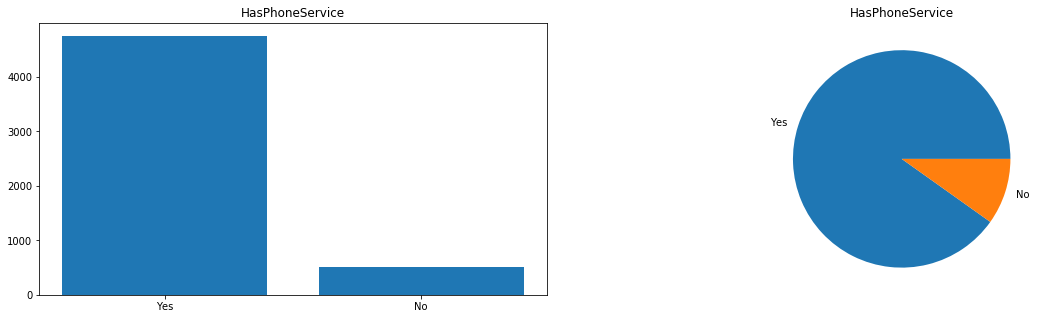

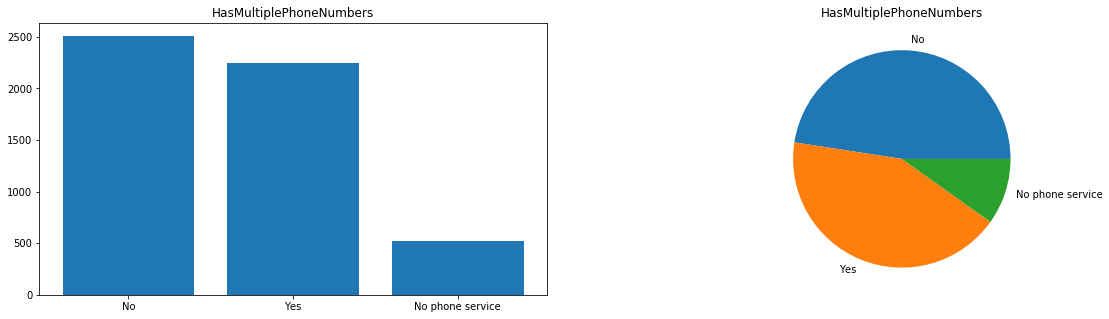

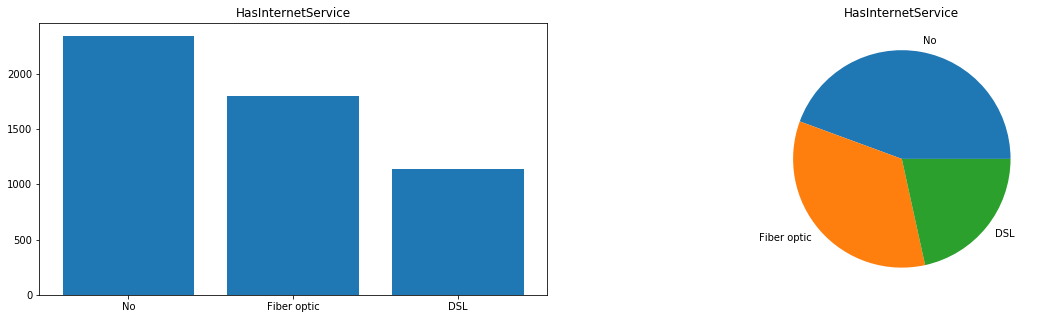

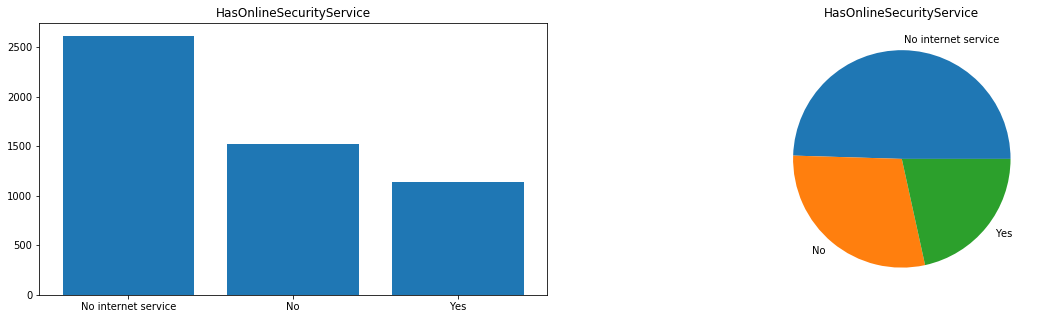

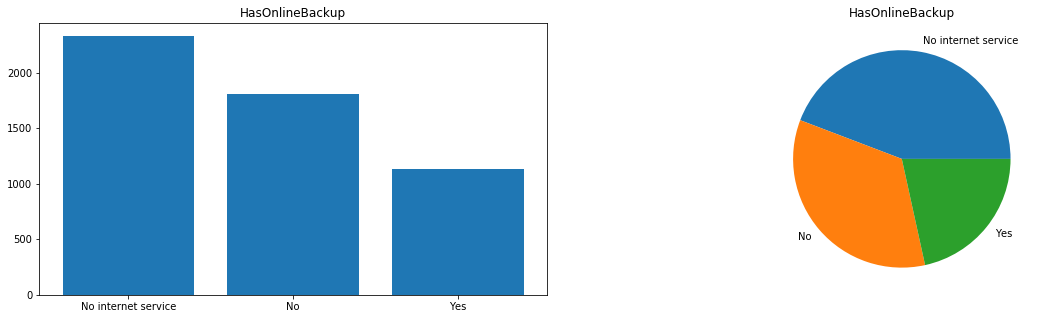

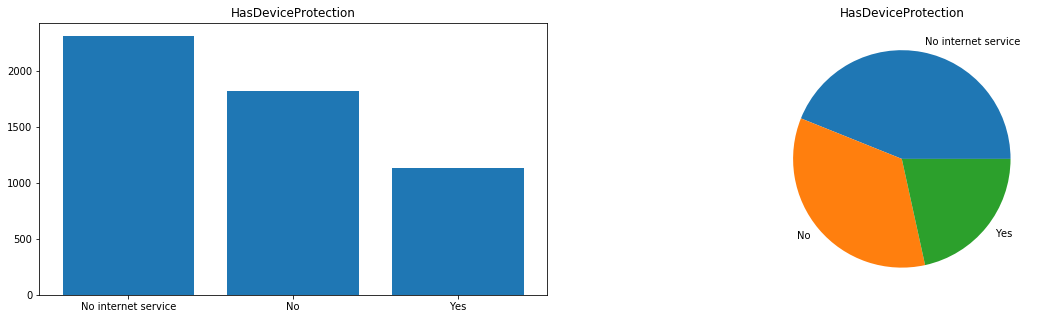

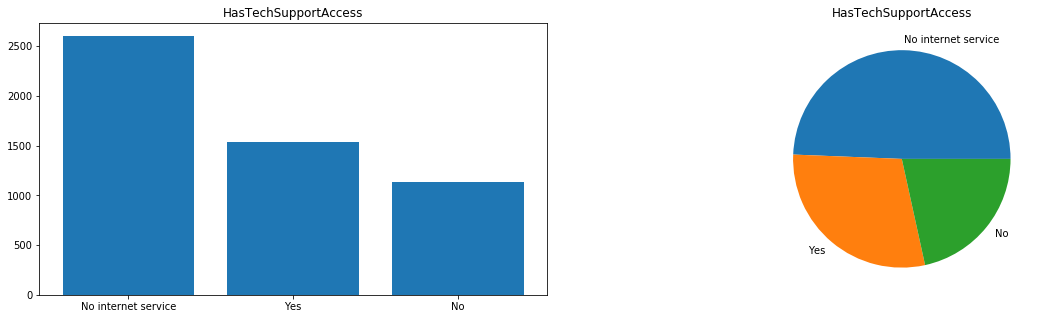

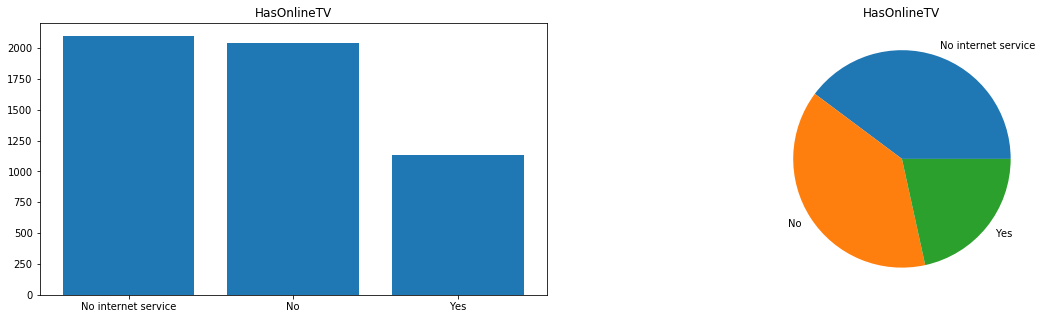

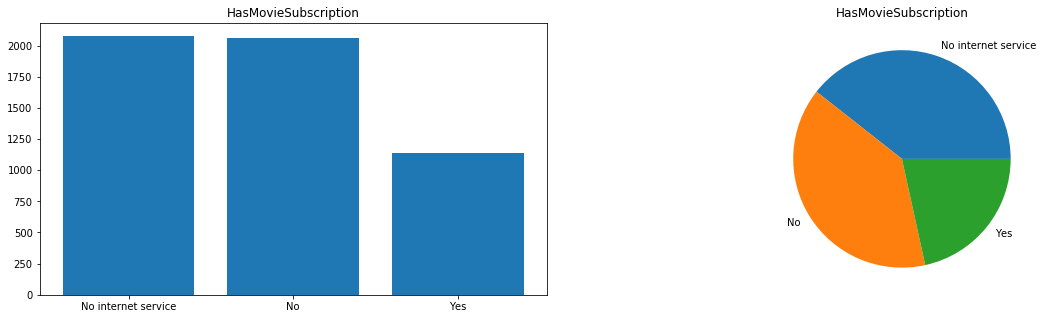

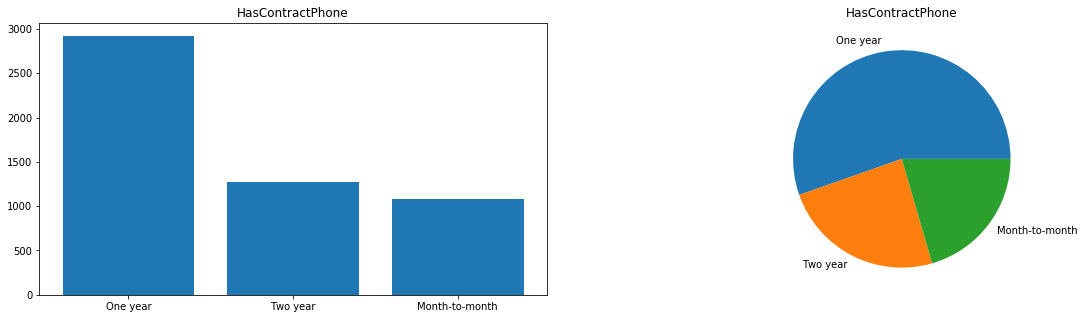

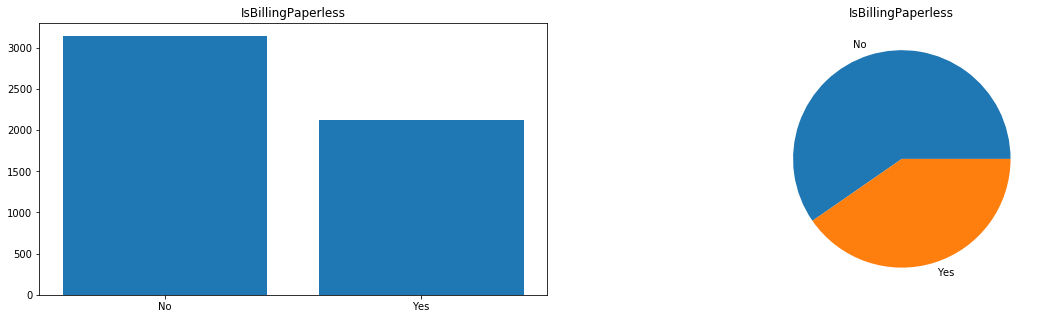

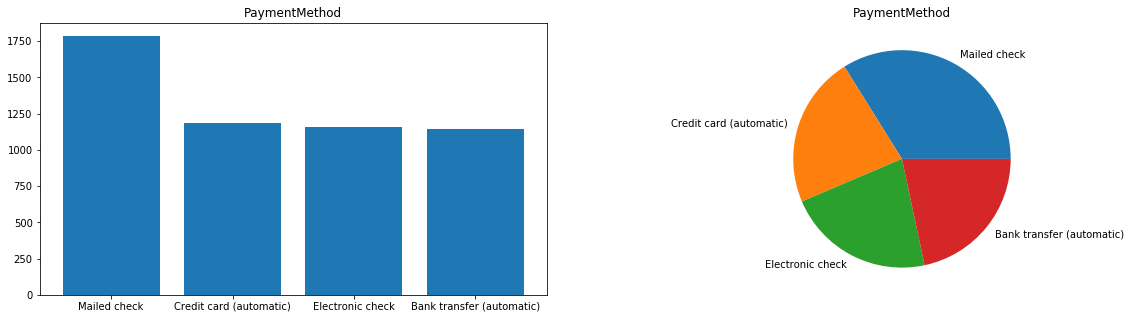

In [9]:
for col in cat_cols:
  fig = plt.figure(figsize=(20, 5))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)
  ax1.bar(data[col].unique(), data[col].value_counts())
  ax2.pie(data[col].value_counts(), labels = data[col].unique())
  ax1.set_title(col)
  ax2.set_title(col)
  plt.show()

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [11]:
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
ClientPeriod,1.00,0.25,0.83,0.01,-0.35
MonthlySpending,0.25,1.00,0.65,0.22,0.18
TotalSpent,0.83,0.65,1.00,0.09,-0.20
IsSeniorCitizen,0.01,0.22,0.09,1.00,0.16
Churn,-0.35,0.18,-0.20,0.16,1.00


## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [12]:
data_new = pd.get_dummies(data, columns=cat_cols)

cat_cols_new = []
for col_name in cat_cols:
    cat_cols_new.extend(filter(lambda x: x.startswith(col_name), data_new.columns))

In [13]:
pca = StandardScaler()
X = pca.fit_transform(data_new[num_cols + cat_cols_new])
y = data_new[target_col]
print(X)

[[ 0.91909879 -1.50643567 -0.55758153 ... -0.52578169 -0.7156732
   1.85433335]
 [ 1.61206004 -1.29599691 -0.18476315 ...  1.90193007 -0.7156732
  -0.53927736]
 [-1.28207223  0.36265822 -0.9765036  ... -0.52578169  1.3972858
  -0.53927736]
 ...
 [-1.28207223 -0.32831    -0.98569348 ... -0.52578169 -0.7156732
   1.85433335]
 [-0.1407243   0.36597222 -0.03355981 ...  1.90193007 -0.7156732
  -0.53927736]
 [-0.54834856  0.36265822 -0.40364547 ... -0.52578169 -0.7156732
   1.85433335]]


In [14]:
gbr_grid_search = GridSearchCV(LogisticRegression(), 
                               [{'C': [5000, 1000, 100, 10, 1, 0.1, 0.01, 0.001]}],
                               cv=5,
                               n_jobs = -1,
                               scoring = 'roc_auc',
                               verbose=10)
gbr_grid_search.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [5000, 1000, 100, 10, 1, 0.1, 0.01, 0.001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=10)

In [15]:
print(gbr_grid_search.best_params_)
print(gbr_grid_search.best_score_)
print(gbr_grid_search.best_estimator_)

{'C': 1000}
0.8448310967426444
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [16]:
# юб
y_pred = gbr_grid_search.predict(X)
roc_auc_score(y, y_pred)

0.7252761605655198

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [45]:
#!pip install catboost

In [17]:
import catboost
X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target_col], test_size=0.2, random_state=None)

In [18]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=cat_cols,
                                             depth = 5,
                                             learning_rate = 0.03,
                                             l2_leaf_reg = 3,
                                             score_function = 'L2',
                                             verbose = False
                                             )

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

In [19]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

print('Train AUC = ', train_auc, 'Test AUC = ', test_auc)

Train AUC =  0.8687081019222758 Test AUC =  0.8432745098039216


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [72]:
best_model = boosting_model

In [104]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission = submission['Churn']
submission.columns = ['Id', 'Churn']
submission.to_csv('./my_submission.csv')

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.